## About this notebook

*[Jigsaw Multilingual Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification)* is the 3rd annual competition organized by the Jigsaw team. It follows *[Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)*, the original 2018 competition, and *[Jigsaw Unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification)*, which required the competitors to consider biased ML predictions in their new models. This year, the goal is to use english only training data to run toxicity predictions on many different languages, which can be done using multilingual models, and speed up using TPUs.

Many awesome notebooks has already been made so far. Many of them used really cool technologies like [Pytorch XLA](https://www.kaggle.com/theoviel/bert-pytorch-huggingface-starter). This notebook instead aims at constructing a **fast, concise, reusable, and beginner-friendly model scaffold**. 

**THIS DOES NOT USE ANY TRANSLATED DATA, BUT IT DOES TRAIN ON THE VALIDATION SET.**


### References
* Original Author: [@xhlulu](https://www.kaggle.com/xhlulu/)
* Original notebook: [Link](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras)

In [1]:
!pip install pyspellchecker
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
tqdm.pandas()
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

import re
from spellchecker import SpellChecker
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.9 MB 402 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [3]:
train1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train2.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,"This is so cool. It's like, 'would you want yo...",0,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,Thank you!! This would make my life a lot less...,0,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,This is such an urgent design problem; kudos t...,0,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,Is this something I'll be able to install on m...,0,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,haha you guys are a bunch of losers.,1,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
valid.shape[0]

8000

In [6]:
test.shape[0]

63812

In [7]:
spell = SpellChecker()

In [8]:

# Counting the number of spelling errors
train1['mispell_count'] = train1['comment_text'].progress_apply(lambda x: len(spell.unknown(x.split())))
train2['mispell_count'] = train2['comment_text'].progress_apply(lambda x: len(spell.unknown(x.split())))

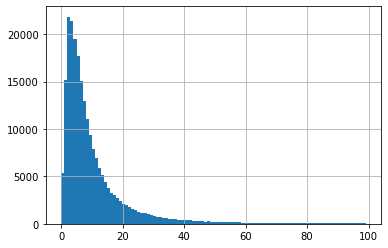

In [9]:
train1[train1['mispell_count'] < 100]['mispell_count'].hist(bins=100)

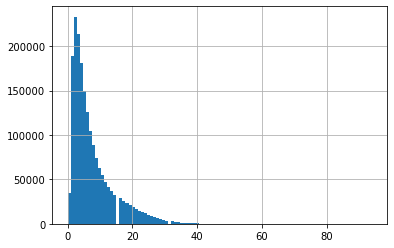

In [10]:
train2[train2['mispell_count'] < 100]['mispell_count'].hist(bins=100)

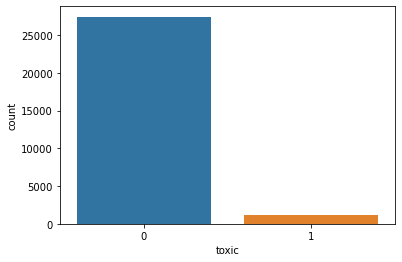

In [11]:
sns.countplot(train1[train1['mispell_count'] >= 20].toxic)

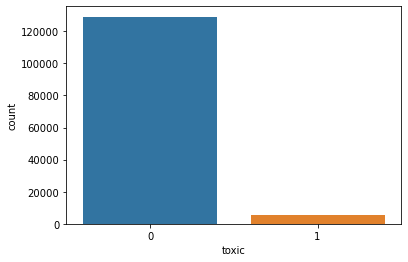

In [12]:
sns.countplot(train2[train2['mispell_count'] >= 20].toxic)

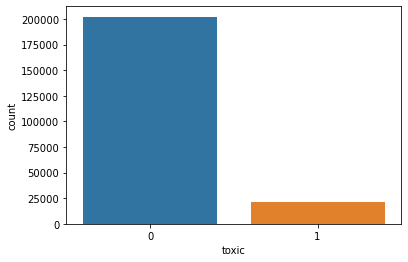

In [13]:
sns.countplot(train1.toxic)

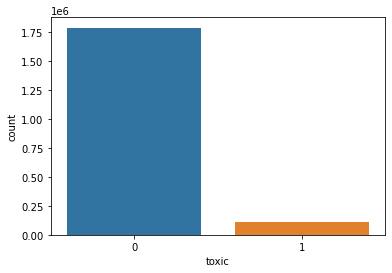

In [14]:
sns.countplot(train2.toxic)

In [15]:
print('train2 has %d entries labeled 1' % train2[['comment_text', 'toxic']].query('toxic==1').shape[0])
print('train1 has %d entries labeled 1' % train1[['comment_text', 'toxic']].query('toxic==1').shape[0])
print('train2 has %d entries labeled 0' % train2[['comment_text', 'toxic']].query('toxic==0').shape[0])
print('train1 has %d entries labeled 0' % train1[['comment_text', 'toxic']].query('toxic==0').shape[0])

train2 has 112226 entries labeled 1
train1 has 21384 entries labeled 1
train2 has 1789968 entries labeled 0
train1 has 202165 entries labeled 0


In [16]:
# Combine train1 with a subset of train2
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=0)
])

## TPU Configs

In [17]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Create fast tokenizer

In [18]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [19]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
MODEL = 'jplu/tf-xlm-roberta-large'

In [20]:
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

## Load text data into memory

In [21]:
%%time 

x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

CPU times: user 4min 49s, sys: 1.87 s, total: 4min 50s
Wall time: 4min 50s


In [22]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Build datasets objects

In [23]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

## Load model into the TPU

In [24]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 559,891,457
Trainable params: 559,891,457
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2min 4s, sys: 37.8 s, total: 2min 42s
Wall time: 3min 47s


## Train Model

First, we train on the subset of the training set, which is completely in English.

In [25]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/2


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


3404/3404 [==============================] - 1453s 427ms/step - loss: 0.0682 - accuracy: 0.9734 - val_loss: 0.3773 - val_accuracy: 0.8699
Epoch 2/2
3404/3404 [==============================] - 1421s 417ms/step - loss: 0.0536 - accuracy: 0.9788 - val_loss: 0.2865 - val_accuracy: 0.8641


Now that we have pretty much saturated the learning potential of the model on english only data, we train it for one more epoch on the `validation` set, which is significantly smaller but contains a mixture of different languages.

In [26]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS
)

Epoch 1/2
62/62 [==============================] - 25s 408ms/step - loss: 0.2378 - accuracy: 0.8892
Epoch 2/2
62/62 [==============================] - 25s 409ms/step - loss: 0.1644 - accuracy: 0.9252


## Submission

In [27]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

499/499 [==============================] - 62s 125ms/step
